In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from shap import TreeExplainer, decision_plot, Explainer
from shap.plots import beeswarm
import matplotlib.pyplot as plt

#### Basic preprocessing

In [4]:
df = pd.read_csv('data/strat.csv')
df.dropna(subset=['MPCE_qrt'], inplace=True)

# Rename state codes to state names
states = pd.read_csv('data/state_codes.csv', header=None, index_col=0)[1].to_dict()
df['state_codes'].replace(states, inplace=True)

# Process binary columns, those that need not be one-hot encoded
df['Urban'] = (df['sector'] == 'Urban').astype(int)
df['HH with children below age 6'] = (df['child'] == 'HH with children beloww age 6 ').astype(int)
df['Piped Gas/LPG Present'] = (df['piped_gas'] == 'Piped Gas/LPG Present').astype(int)

# Rename MPCE quartiles to be more readable
df['MPCE_qrt'].replace({'50-75': 'Third MPCE Quartile', '0-25': 'Lowest MPCE Quartile', '25-50': 'Second MPCE Quartile', '75-100': 'Top MPCE Quartile'}, inplace=True)

df.head()

,Age,Gender,state_codes,Total Children in HH,Total Women in HH,Total Additional Women in HH,education,marital_status,employment,Social_group_,...,Time Spent Cleaning,Time Spent Collecting Firewood,Time Spent Washing,Time Spent on Domestic Chores,Time Spent on Care Work,young_old,stratcode,Urban,HH with children below age 6,Piped Gas/LPG Present
0,67,Male,Tamil Nadu,1.0,2,1,Secondary,Currently Married,Self-Employed,OBC,...,0.0,0.0,0.0,0.0,45.0,Old,Old_TN_Male_OBC_Hinduism_Rural,0,1,1
1,61,Female,Tamil Nadu,1.0,2,1,Upto Middle School,Currently Married,Casual Labour,OBC,...,0.0,0.0,0.0,165.0,60.0,Old,Old_TN_Female_OBC_Hinduism_Rural,0,1,1
2,33,Male,Tamil Nadu,1.0,2,1,Secondary,Currently Married,Salaried Employee,OBC,...,0.0,0.0,0.0,0.0,15.0,Young,Young_TN_Male_OBC_Hinduism_Rural,0,1,1
3,26,Female,Tamil Nadu,1.0,2,1,Secondary,Currently Married,Not Employed,OBC,...,90.0,0.0,120.0,345.0,120.0,Young,Young_TN_Female_OBC_Hinduism_Rural,0,1,1
4,70,Female,Tamil Nadu,0.0,1,0,Illiterate,Widowed,Not Employed,OBC,...,0.0,0.0,0.0,105.0,0.0,Old,Old_TN_Female_OBC_Hinduism_Rural,0,0,1


In [5]:
def modify_ax(ax, title):
    """Shap's beeswarm plots offer very little customization by themselves.
    Use this function to modify the axis objects."""
    ax.set_title(title, fontsize='x-large', pad=20)
    ax.tick_params(axis='y', labelsize='large')
    ax.set_xlabel('Deviation from average time spent (in hours)', fontsize='large')

### Eqn 1: Determinants of time spent on paid and unpaid work by men and women
> These results are mostly fine, the swarmplots can be reported as they are.

_Caution_: The beeswarm plots take a long time. Reduce the `n_samples` variable below to get faster results, but with fewer samples.

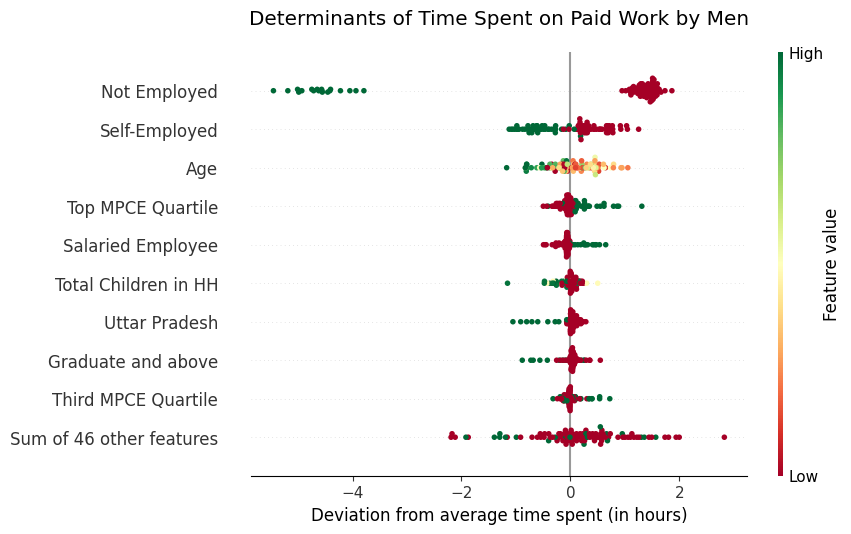

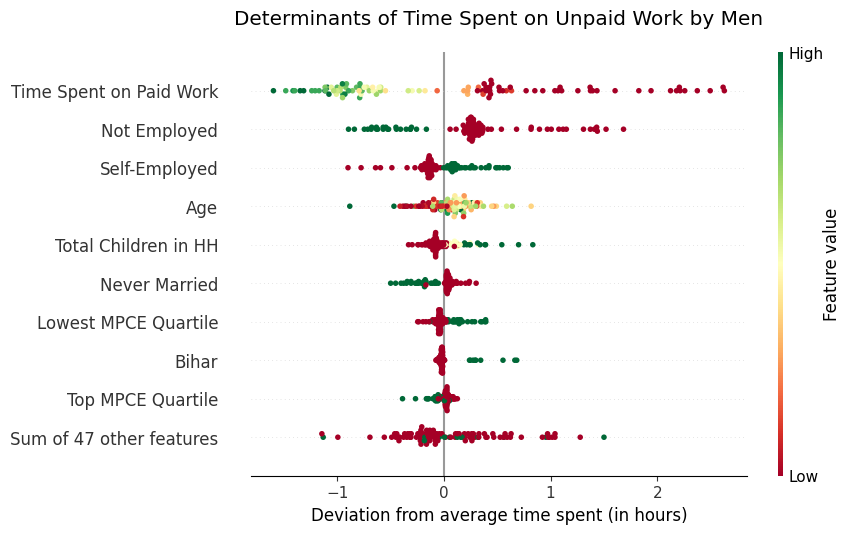

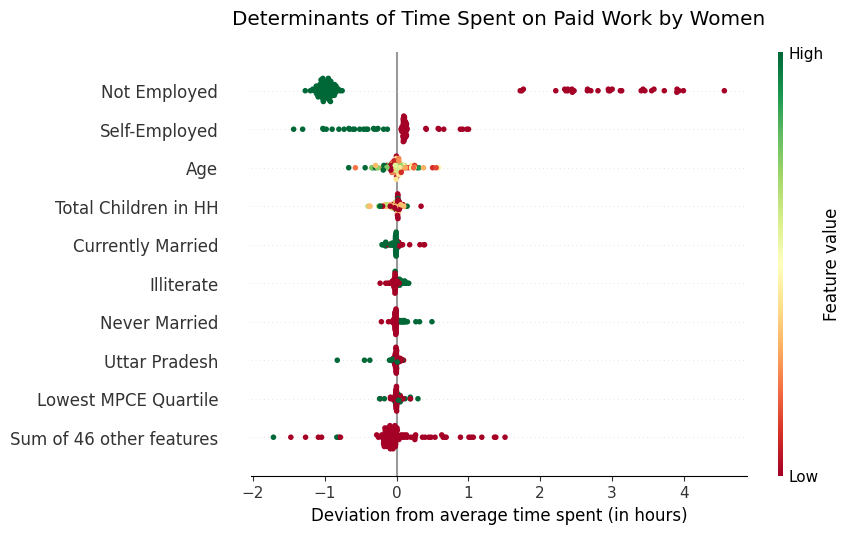

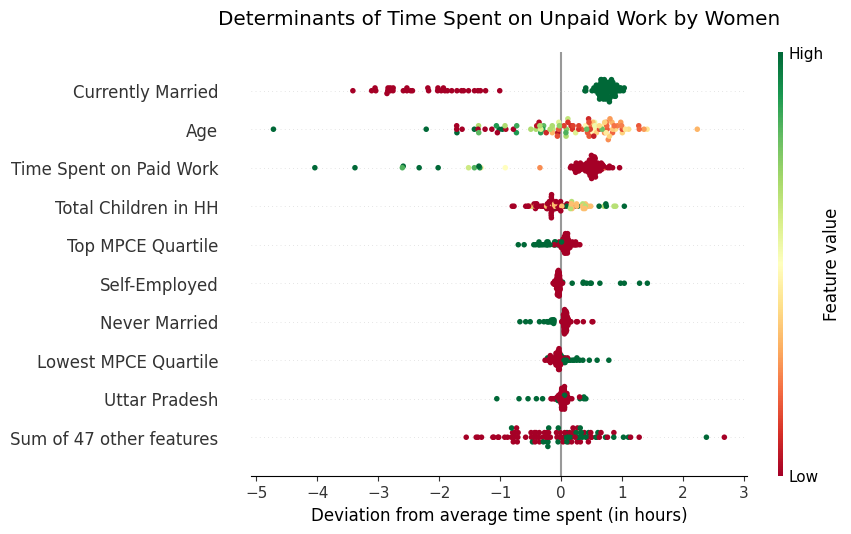

In [6]:
n_samples = 100

genders = ['Male', 'Female']
targets = ['Time Spent on Paid Work', 'Time Spent on Unpaid Work']
genderwise_feats = {'Male': 'Total Women in HH', 'Female': 'Total Additional Women in HH'}

categorical_feats = ['education', 'marital_status', 'employment', 'state_codes', 'MPCE_qrt']
numerical_feats = ['Total Children in HH', 'Age']  # a genderwise feature to be added here when fitting the regressions

for gender in genders:
    xdf = df[df['Gender'] == gender]
    num_feats = numerical_feats + [genderwise_feats[gender]]

    x_cat = pd.get_dummies(xdf[categorical_feats], prefix='', prefix_sep='', drop_first=False, dtype=int)
    x_num = xdf[numerical_feats]
    X = pd.concat((x_cat, x_num), axis=1)
    
    for target in targets:
        y = xdf[target] / 60
        X[target] = y
        xtrain, xtest = train_test_split(X, stratify=xdf['stratcode'], test_size=0.2)
        ytrain, ytest = xtrain.pop(target), xtest.pop(target)
    
        clf = RandomForestRegressor(n_estimators=40, n_jobs=-1)
        clf.fit(xtrain, ytrain)
        
        exp = TreeExplainer(clf, feature_perturbation='tree_path_dependent')
        vals = exp(xtest.sample(n_samples), check_additivity=False)
        
        plt.figure()
        beeswarm(vals, color='RdYlGn', show=False)
        tname = "Men" if gender == "Male" else "Women"
        modify_ax(plt.gca(), f"Determinants of {target} by {tname}")

---

In [7]:
target_names = ['Time Spent on Paid Work',
                'Time Spent on Unpaid Work',
                'Time Spent on Leisure',
                'Time Spent Cooking',
                'Time Spent Cleaning',
                'Time Spent Collecting Firewood',
                'Time Spent Washing',
                'Time Spent on Domestic Chores',
                'Time Spent on Care Work']
resultdf = pd.DataFrame({'target': target_names, 'train': 0, 'test': 0})
xdf = df[df['Gender'] == 'Female']
feats = ['Social_group_', 'religion', 'Urban', 'MPCE_qrt', 'Age', 'education', 'employment', 'marital_status', 'Piped Gas/LPG Present', 'wired_source', 'sweeeping_type', 'HH with children below age 6',
         'old', 'n_unemp_men', 'state_codes']
catCols = feats.copy()
numCols = ['Age', 'n_unemp_men', 'Urban', 'Piped Gas/LPG Present', 'HH with children below age 6']
for numCol in numCols:
    catCols.remove(numCol)


xCat = pd.get_dummies(xdf[catCols], prefix='', prefix_sep='', dtype=int)
xNum = xdf[numCols]
X = pd.concat((xCat, xNum, xdf[target_names + ['stratcode']]), axis=1)

<Axes: >

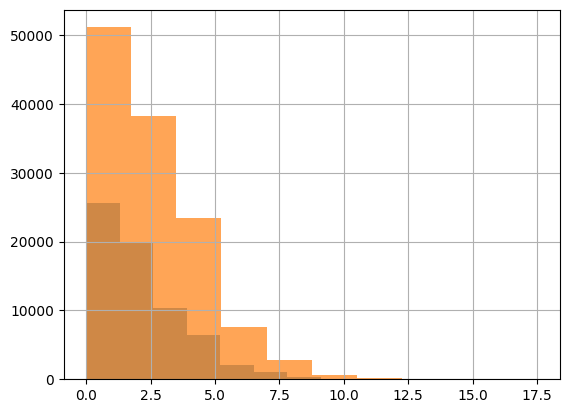

In [18]:
time_with_ch = X[X['HH with children below age 6'] == 1]['Time Spent on Leisure'] / 60
time_wo_ch = X[X['HH with children below age 6'] == 0]['Time Spent on Leisure'] / 60
fig, ax = plt.subplots()
time_with_ch.hist(ax=ax, label='Children below 6', alpha=0.7)
time_wo_ch.hist(ax=ax, label='No children below 6', alpha=0.7)

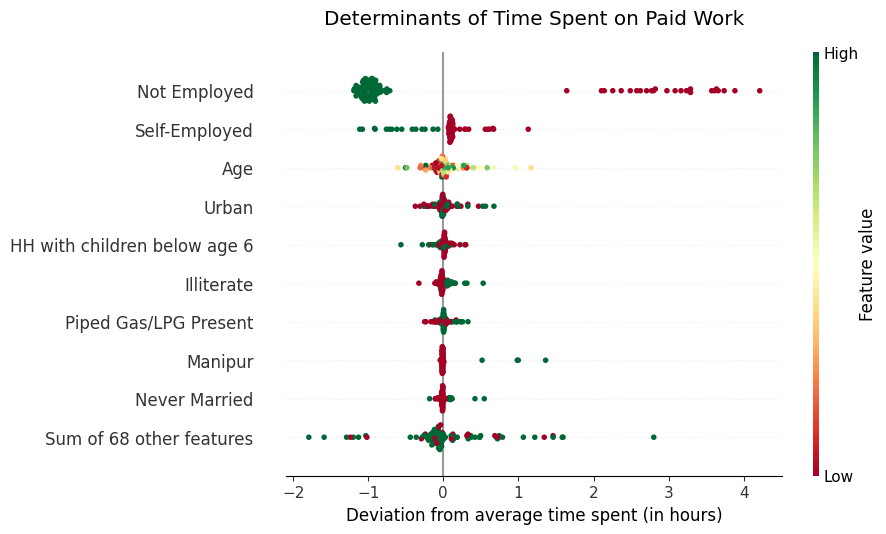

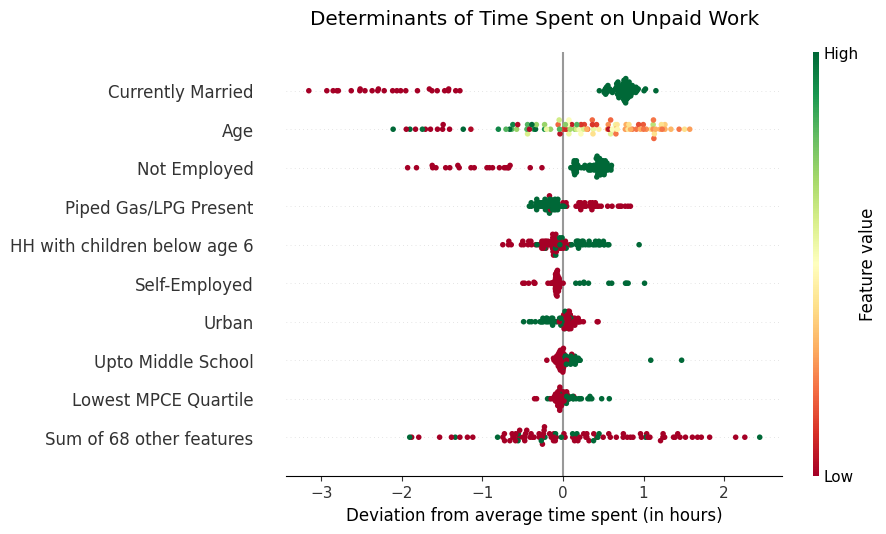

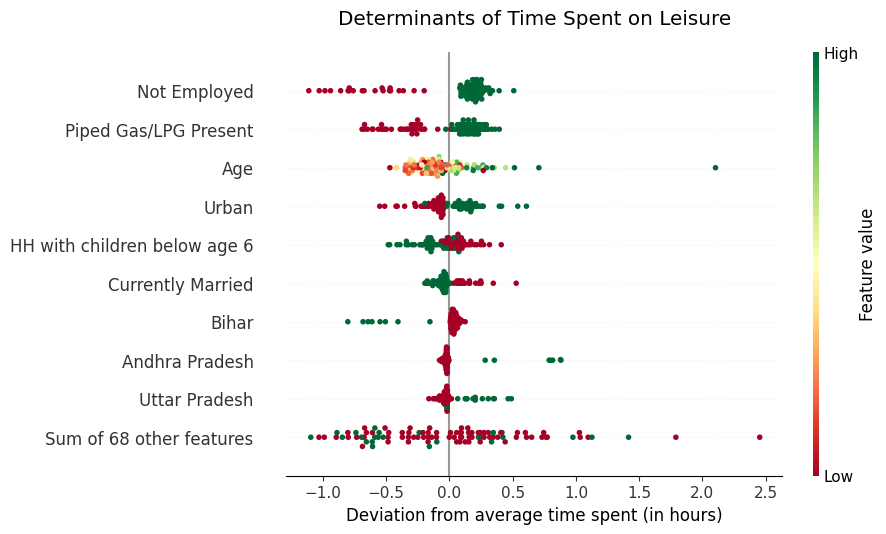

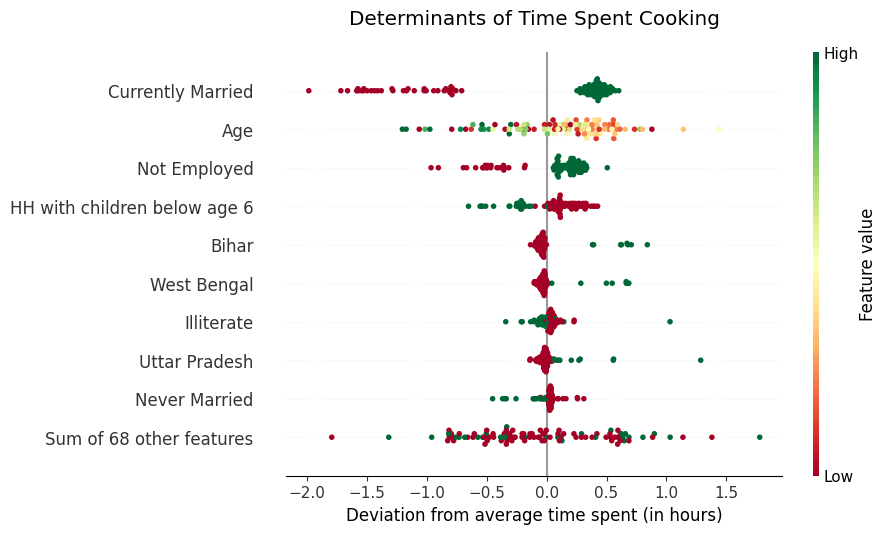

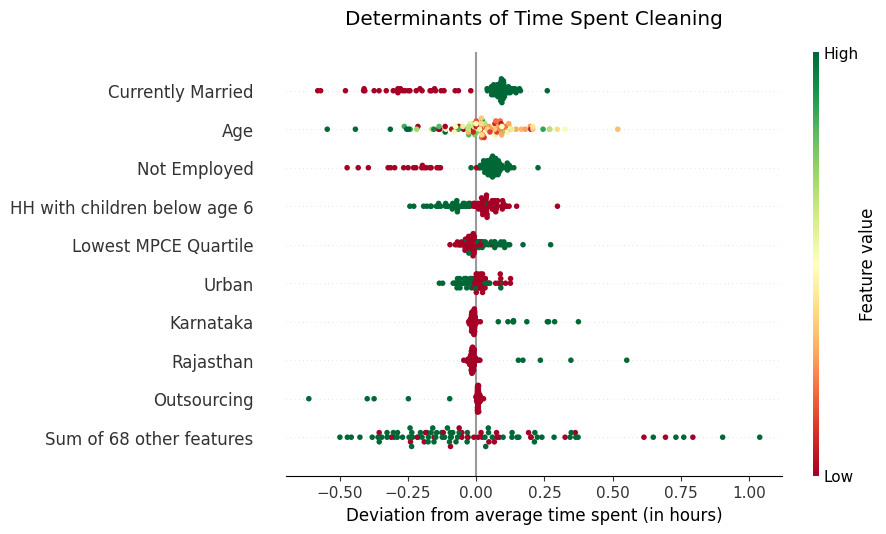

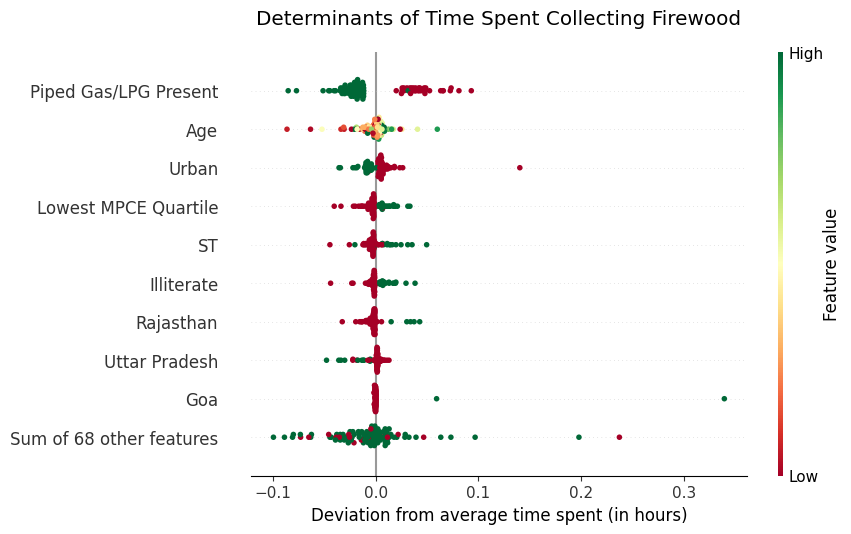

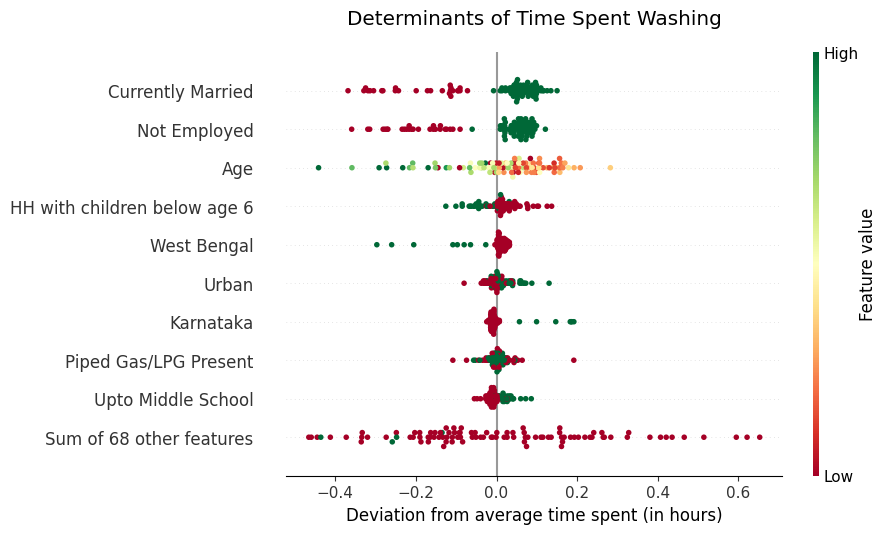

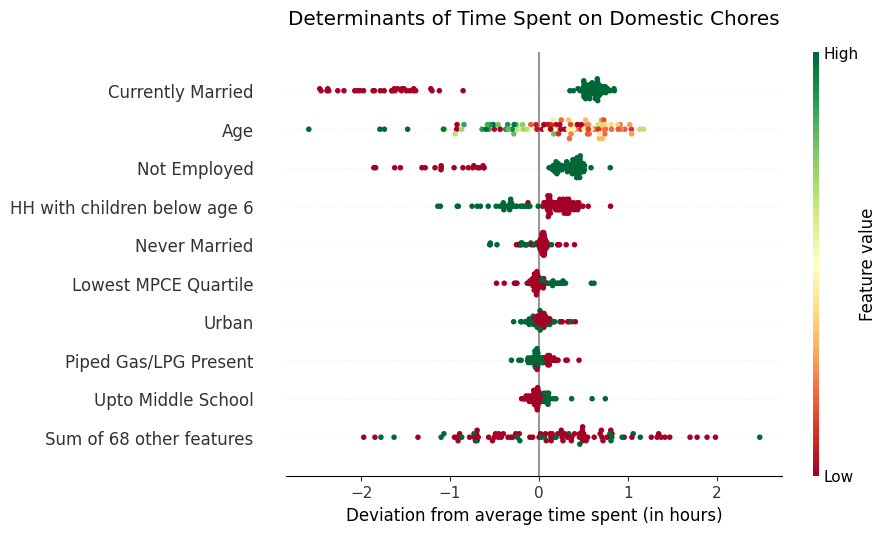

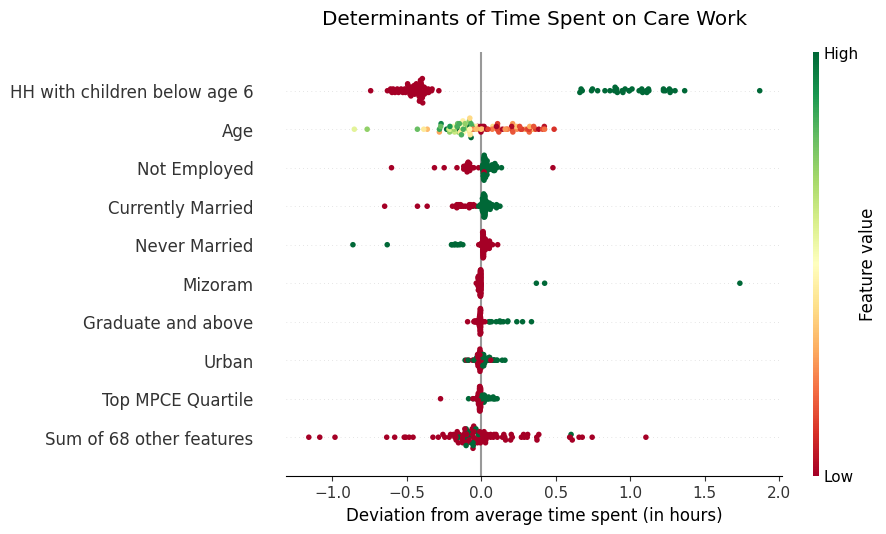

In [11]:
results = []
for t in target_names:
    # xtrain, xtest = train_test_split(X, stratify=X['stratcode'], test_size=0.1)
    # dftrain = xtrain.drop(target_names + ['stratcode'], axis=1)
    # dftest = xtest.drop(target_names + ['stratcode'], axis=1)
    # ytrain = xtrain[t]
    # ytest = xtest[t]
    xtrain = X.drop(target_names + ['stratcode'], axis=1)
    ytrain = X[t]
    clf = RandomForestRegressor(n_jobs=-1)
    clf.fit(xtrain, ytrain / 60)

    exp = TreeExplainer(clf, feature_perturbation='tree_path_dependent')
    vals = exp(xtrain.sample(100), check_additivity=False)
    plt.figure()
    beeswarm(vals, color='RdYlGn', show=False)
    modify_ax(plt.gca(), f"Determinants of {t}")

In [19]:
pd.DataFrame(results)

,target,score
0,Time Spent on Paid Work,0.471720
1,Time Spent on Unpaid Work,0.400648
2,Time Spent on Leisure,0.031780
3,Time Spent Cooking,0.301376
4,Time Spent Cleaning,-0.033984
5,Time Spent Collecting Firewood,-0.228815
6,Time Spent Washing,-0.000989
7,Time Spent on Domestic Chores,0.332476
8,Time Spent on Care Work,0.303619


In [26]:
pd.DataFrame(results)

""


In [17]:
pd.read_csv('data/cv_results_eqn3.csv')

,Target,RF (Train),RF (Test),DT (Train),DT (Test),LR (Train),LR (Test)
0,Time Spent on Paid Work,0.905003,0.499561,0.963802,0.114214,0.529253,0.526948
1,Time Spent on Unpaid Work,0.875495,0.432615,0.936309,0.051024,0.430881,0.434792
2,Time Spent on Leisure,0.792833,0.081411,0.888682,-0.522495,0.180908,0.178289
3,Time Spent Cooking,0.850811,0.331322,0.921379,-0.112898,0.344989,0.349894
4,Time Spent Cleaning,0.773613,0.024703,0.873661,-0.628305,0.126290,0.119419
5,Time Spent Collecting Firewood,0.733928,-0.147928,0.848987,-0.907321,0.041125,0.037825
6,Time Spent Washing,0.782255,0.039036,0.881504,-0.578742,0.143269,0.143032
7,Time Spent on Domestic Chores,0.859908,0.362353,0.926641,-0.070041,0.370626,0.366511
8,Time Spent on Care Work,0.849321,0.347228,0.916062,-0.098721,0.382243,0.384557
